# Реализуем алгоритм решения задачи

Начнём с того, что определимся с кодовой структурой алгоритма.
Пусть за решение задачи отвечает функция с говорящим названием `solve` и пусть на вход она принимает экземпляр задачи `Task`, сопла `Nozzle` и величину давления окружающей среды.

В качестве возвращаемого значения хотелось бы получить ответы на все вопросы задания.
Но их достаточно много (различные тяги, скорости и т.д.).
Поэтому заведём ещё один класс данных (dataclass), назовём его `Solution`.
Так пусть `solve` возвращает экземпляр этого класса.

Другими словами, мы напишем функцию со следующей _сигнатурой_:

```{code} python
def solve(task: Task, noz: Nozzle, p_a: float) -> Solution:
```

Сведём воедино весь код, который мы до сих пор написали:

In [1]:
import numpy as np
from dataclasses import dataclass
from math import sqrt, tan, pi


# Описание задачи
@dataclass(frozen=True) # "Заморозили" класс - у экземпляра невозможно будет изменять значения полей
class Task:             # (это защитит нас от случайных изменений данных).
    variant: float          # № варианта
    p0: float               # float - тип данных (вещественное число)
    T0: float
    R: float
    k: float
    d_critic: float         # Обратите внимание:
    area_ratio: float       # в коде лучше использовать более говорящие
    d_chamber: float        # имена переменных, чем принято в математике.
    alpha: float            # Это улучшает читаемость кода (в первую очередь, для вас самих).
    beta: float             # В целом наша задача чисто расчётная и в ней не так много переменных,
    rel_propel_mass: float  # поэтому ряд значений мы обозначили близко к математике в методичке.


# Описание сопла
class Nozzle:
    # __init__ - это конструктор экземпляра класса,
    # т.е. тот код, который выполняется при создании объекта класса
    def __init__(self,
                 d_chamber: float,
                 d_critic: float,
                 area_ratio: float,
                 confuser_angle: float,
                 diffuser_angle: float):
        self.d_chamber = d_chamber
        self.d_critic = d_critic
        self.area_ratio = area_ratio
        self.alpha = confuser_angle
        self.beta = diffuser_angle
        # Расчётные параметры вынесем в отдельный приватный метод
        self._init_geometry()
    
    # Данный метод является приватным - его имя начинается с _.
    # Вне класса этот метод напрямую недоступен.
    def _init_geometry(self):
        # Выполняем расчёт по формулам.
        self.d_out = self.d_critic * sqrt(self.area_ratio)
        self.x_critic = 0.5*(self.d_chamber - self.d_critic) / tan(self.alpha)
        self.x_out = self.x_critic + 0.5*(self.d_out - self.d_critic) / tan(self.beta)
        self.area_critic = 0.25 * pi * self.d_critic**2
    
    # Метод для расчёта d(x)
    def diameter_at(self, x):
        x = np.asarray(x)
        d = np.empty_like(x, dtype=np.float64)
        confuser = x < self.x_critic
        d[confuser] = \
            self.d_chamber \
            - (self.d_chamber - self.d_critic) * x[confuser]/self.x_critic
        diffuser = x >= self.x_critic
        d[diffuser] = \
            self.d_critic \
            + (self.d_out - self.d_critic) \
            * (x[diffuser] - self.x_critic)/(self.x_out - self.x_critic)
        return d


# Газодинамические функции
def temp_ratio(mach: float, k: float):
    return 1 + 0.5*(k - 1) * mach**2

def dens_ration(mach: float, k: float):
    return temp_ratio(mach, k)**(1/(k - 1))

def press_ratio(mach: float, k: float):
    return temp_ratio(mach, k)**(k/(k - 1))

def square_ratio(mach: float, k: float):
    a = (k + 1) / (2*(k - 1))
    return 1/mach * (2/(k + 1))**a * temp_ratio(mach, k)**a

def lambda2mach(lam: float, k: float):
    return lam * np.sqrt(2/(k + 1) / (1 - (k - 1)/(k + 1) * lam**2))

def mach2lambda(mach: float, k: float):
    return mach * np.sqrt(0.5*(k + 1) / temp_ratio(mach, k))

def sonic(k: float, R: float, T: float):
    return np.sqrt(k * R * T)

## Класс результатов решения `Solution`

В результате решения первой части задания (до задачи приведения геометрии сопла под расчётный режим) должны быть построены графики $p(x)$, $\rho(x)$, $T(x)$, $S(x)$, $j(x)$, $G(x) = j(x) S(x)$, $\mathrm{M}(x)$, $\lambda(x)$ и рассчитаны величины $G$ (постоянный массовый расход), тяги $P$, $P_\mathrm{уд}$, $P_\mathrm{вак}$ и $P_\mathrm{уд.вак}$, скорость газа на выходе $v_\mathrm{в}$, давление газа на выходе $p_\mathrm{в}$, скорость идеальной ракеты $v$, степень нерасчётности сопла $\Delta_p$.

Пусть эти данные хранятся в классе `Solution`.
Для разнообразия и общего развития сделаем возможность читабельного вывода экземпляра решения, добавив метод `as_dict`, который возвращает поля экземпляра в виде Python-словаря.

In [2]:
# Описание решения
@dataclass(frozen=True)
class Solution:
    x: np.ndarray               # массив координат расчётных точек
    square: np.ndarray          # массив площадей сечений в точках x
    mach: np.ndarray            # массив чисел Маха
    pressure: np.ndarray        # массив значений статического давления
    density: np.ndarray         # ... плотности
    temperature: np.ndarray     # ... температуры
    specific_mass: np.ndarray   # ... плотности потока массы
    mass_consumption: float     # массовый расход
    speed_out: float            # скорость газа на выходе
    pressure_out: float         # давление на выходе
    thrust: float               # тяга
    thrust_specific: float      # удельная тяга
    thrust_space: float         # тяга в пустоте
    thrust_specific_space: float    # удельная тяга в пустоте
    ideal_speed: float          # скорость идеальной ракеты
    adapted_level: float        # степень нерасчётности сопла

    def as_dict(self):
        return {
            "Массовый расход, кг/с": float(self.mass_consumption),
            "Скорость потока на выходе, м/с": float(self.speed_out),
            "Давление на выходе, Па": float(self.pressure_out),
            "Тяга, Н": float(self.thrust),
            "Удельная тяга, м/с": float(self.thrust_specific),
            "Тяга в пустоте, Н": float(self.thrust_space),
            "Удельная тяга в пустоте, м/с": float(self.thrust_specific_space),
            "Скорость идеальной ракеты, м/с": float(self.ideal_speed),
            "Степень нерасчётности сопла": \
                f"{float(self.adapted_level)} " + (
                    "(недорасширение)" if self.adapted_level < 1 
                    else "(перерасширение)"
                )
        }

## Решающая функция

Для начала вспомним, как по известной геометрии сопла определить параметры течения газа в нём.
Посмотрите уравнение (15) в [методичке](https://press.bmstu.ru/catalog/item/7208/) и пояснения к нему.
Это уравнение имеет следующий вид:

$$
f(\mathrm{M}) =
S - \frac{S_*}{\mathrm{M}}
\left(
    \frac{2}{k+1}
\right)^{\cfrac{k+1}{2 (k-1)}}
\left(
    1 + \frac{k-1}{2} \mathrm{M}^2
\right)^{\cfrac{k+1}{2 (k-1)}}
= 0.
$$ (eq_f_M)

Из этого [_трансцендентного_](https://ru.wikipedia.org/wiki/Трансцендентное_уравнение) уравнения и находится (численно) число Маха в сечении, имеющем площадь $S$.

В отличие от основного пособия мы не будем использовать метод половинного деления, тем более не будем сами реализовывать метод численного поиска корня.
Это интересная алгоритмическая задача, но для нас как инженеров гораздо важнее знать возможности современных инструментов и то, что конкретно и как применять для решения той или иной задачи.
Поэтому мы воспользуемся библиотекой SciPy, в которой на низкоуровневых быстрых языках программирования реализованы различные методы поиска корней.

Импортируем пакет численной оптимизации `scipy.optimize`:

In [3]:
import scipy.optimize as opti

```{note}
Не пугайтесь того, что мы используем функцию из пакета для оптимизации.
В программировании поиск корня — это одна из задач оптимизации.
```

Как записать наше уравнение $f(\mathrm{M}) = 0$ в коже?
Очень просто! В виде функции, возвращающей значение выражения {eq}`eq_f_M`:

In [4]:
def area_equation(mach: float, s: float, s_critic: float, k: float):
    return s - s_critic*square_ratio(mach, k)

Суть численного поиска корня уравнения сводится к тому, что алгоритм поиска вызывает функцию `area_equation`, передавая её начальное приближения значения числа Маха `mach` (разные алгоритмы вырабатывают это значение из разных соображений).
Функция в ответ даёт значение выражения `s - s_critic*square_ratio(mach, k)`.
На основании этого ответа алгоритм вырабатывает новое приближение переменной `mach` и снова вызывает функцию `area_equation`.
И так до тех пор, пока _с заданной точностью_ не будет выполнено равенство выражения `s - s_critic*square_ratio(mach, k)` нулю, то есть равенство {eq}`eq_f_M`.

Для поиска корня будем использовать функцию `opti.root_scalar` из библиотеки SciPy.
Почитайте об этом методе в [официальной документации](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.root_scalar.html).
Корень уравнения {eq}`eq_f_M` будем искать в функции `solve`.
Опишем, наконец, эту функцию:

In [5]:
# На входе функции у нас уже есть все необходимые данные:
# экземпляры задания task, сопла noz и внешнего давления p_a
def solve(task: Task, noz: Nozzle, p_a: float):
    # Создаём массив расчётных точек по оси сопла
    x = np.linspace(0, noz.x_out, 300)
    # Уже легко посчитать площади сечений
    # (помните, что в методе diameter_at мы позаботились
    # о возможности считать массивами?)
    S = 0.25 * np.pi * noz.diameter_at(x)**2
    # Начинаем численно искать числа Маха в сечениях
    mach = []
    for xi, si in zip(x, S):
        # Передаём нашу функцию с уравнением,
        # дополнительные аргументы этой функции (args)
        # и bracket - диапазон поиска корня
        sol = opti.root_scalar(
            area_equation,
            args=(si, 0.25*np.pi*noz.d_critic**2, task.k),
            bracket=[1e-6, 1] if xi < noz.x_critic else [1, 10]
        ).root
        # Сохраняем корень
        mach.append(sol)
    # Готово! Все корни найдены.
    # Теперь преобразуем Python-список в массив NumPy
    mach = np.array(mach)
    # Далее по формулам рассчитываем параметры течения
    p = task.p0 / press_ratio(mach, task.k)
    rho0 = task.p0 / (task.R * task.T0)
    rho = rho0 / dens_ration(mach, task.k)
    T = task.T0 / temp_ratio(mach, task.k)
    v = mach * sonic(task.k, task.R, T)
    j = rho * v
    G = task.p0*noz.area_critic \
        * np.sqrt(task.k / task.R / task.T0) \
        * (2 / (task.k + 1))**(0.5*(task.k + 1)/(task.k - 1))
    v_out = v[-1]
    P = G*v_out + S[-1]*(p[-1] - p_a)
    P_spec = P / G
    P_space = G*v_out + S[-1]*p[-1]
    P_space_spec = P_space / G
    v_ideal = -P_space_spec*np.log(1 - task.rel_propel_mass)
    # И в итоге возвращаем экземпляр Solution
    return Solution(
        x, S, mach, p, rho, T, j,
        G, v_out, p[-1],
        P, P_spec, P_space, P_space_spec, v_ideal,
        p_a / p[-1]
    )

Запись

```{code} python
bracket=[1e-6, 1] if xi < noz.x_critic else [1, 10]
```

означает следующее.
Если `xi < noz.x_critic` (конфузор сопла), то ищи корень (число Маха) на отрезке от $10^{-6}$ до $1$, поскольку в конфузоре течение газа дозвуковое.
Иначе (в диффузоре) корень ищи на отрезке от $1$ до $10$ (просто большое значение).

Задав `bracket`, мы тем самым неявно выбрали метод Брента [brentq](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.brentq.html) в качестве алгоритма оптимизации.

### Тестовый расчёт

Посчитаем тестовый вариант.
Для этого:

1. Создаём экземпляр задачи `Task`:

In [6]:
from math import radians

task = Task(
    variant=0,
    p0=5.4e6,     # Па
    T0=2705,    # К
    R=325,      # Дж/(кг К)
    k=1.24,
    d_critic=0.6,       # м
    area_ratio=6,
    d_chamber=3.5*0.6,  # м
    alpha=radians(45),  # радианы
    beta=radians(9),    # радианы
    rel_propel_mass=0.8
)

2. Создаём экземпляр сопла `Nozzle`:

In [7]:
noz = Nozzle(
    d_chamber=task.d_chamber,
    d_critic=task.d_critic,
    area_ratio=task.area_ratio,
    confuser_angle=task.alpha,
    diffuser_angle=task.beta
)

3. Вызываем решатель `solve`:

In [8]:
sol = solve(task, noz, p_a=1e5)

4. Смотрим результаты:

In [9]:
from pprint import pprint

pprint(sol.as_dict())

{'Давление на выходе, Па': 122502.34808174215,
 'Массовый расход, кг/с': 1068.5320756512886,
 'Скорость идеальной ракеты, м/с': 3809.111588743622,
 'Скорость потока на выходе, м/с': 2172.24266404392,
 'Степень нерасчётности сопла': '0.8163108835536197 (недорасширение)',
 'Тяга в пустоте, Н': 2528931.3000909286,
 'Тяга, Н': 2359285.29679708,
 'Удельная тяга в пустоте, м/с': 2366.7340997222773,
 'Удельная тяга, м/с': 2207.9686240200654}


```{note}
Вывод очень большой ввиду того, что в решении хранится несколько массивов по 200 элементов каждый.
Но вы можете сравнить полученные значения тяг и скорости ракеты, а также степень нерасчётности сопла с результатами в методическом пособии (они совпадают).
```

### Визуализация результатов

Подключаем Matplotlib и строим графики:

In [10]:
import matplotlib.pyplot as plt

def make_plots(task: Task, noz: Nozzle, sol: Solution):
    # Площадь
    fig_s, ax_s = plt.subplots(num="square")
    ax_s.plot(sol.x, sol.square, c="k")
    ax_s.axvline(noz.x_critic, ls="--", c="k")
    ax_s.set(xlabel="$x$, м", ylabel="$S(x)$, м$^2$")
    ax_s.grid(True, ls=":", c="k")

    # Число Маха
    fig_mach, ax_mach = plt.subplots(num="Mach")
    ax_mach.plot(sol.x, sol.mach, c="k")
    ax_mach.set(xlabel="$x$, м", ylabel=r"$\mathrm{M}$")
    ax_mach.axvline(noz.x_critic, ls="--", c="k")
    ax_mach.grid(True, ls=":", c="k")

    # Безразмерная скорость
    fig_lambda, ax_lambda = plt.subplots(num="lambda")
    ax_lambda.plot(sol.x, mach2lambda(sol.mach, task.k), c="k")
    ax_lambda.set(xlabel="$x$, м", ylabel=r"$\lambda$")
    ax_lambda.axvline(noz.x_critic, ls="--", c="k")
    ax_lambda.grid(True, ls=":", c="k")

    # Давление
    fig_p, ax_p = plt.subplots(num="pressure")
    ax_p.plot(sol.x, sol.pressure*1e-6, c="k")
    ax_p.set(xlabel="$x$, м", ylabel=r"$p$, МПа")
    ax_p.axvline(noz.x_critic, ls="--", c="k")
    ax_p.grid(True, ls=":", c="k")

    # Плотность
    fig_dens, ax_dens = plt.subplots(num="density")
    ax_dens.plot(sol.x, sol.density, c="k")
    ax_dens.set(xlabel="$x$, м", ylabel=r"$\rho$, кг/м$^3$")
    ax_dens.axvline(noz.x_critic, ls="--", c="k")
    ax_dens.grid(True, ls=":", c="k")

    # Температура
    fig_temp, ax_temp = plt.subplots(num="temperature")
    ax_temp.plot(sol.x, sol.temperature, c="k")
    ax_temp.set(xlabel="$x$, м", ylabel=r"$T$, К")
    ax_temp.axvline(noz.x_critic, ls="--", c="k")
    ax_temp.grid(True, ls=":", c="k")

    # Плотность потока массы
    fig_j, ax_j = plt.subplots(num="j")
    ax_j.plot(sol.x, sol.specific_mass, c="k")
    ax_j.set(xlabel="$x$, м", ylabel=r"$j$, кг/(с $\cdot$ м$^2$)")
    ax_j.axvline(noz.x_critic, ls="--", c="k")
    ax_j.grid(True, ls=":", c="k")

    # Массовый расход
    fig_G, ax_G = plt.subplots(num="G")
    ax_G.plot(sol.x, sol.specific_mass*sol.square, c="k")
    ax_G.set(xlabel="$x$, м", ylabel=r"$G$, кг/с")
    ax_G.axvline(noz.x_critic, ls="--", c="k")
    ax_G.grid(True, ls=":", c="k")

Вызываем и получаем:

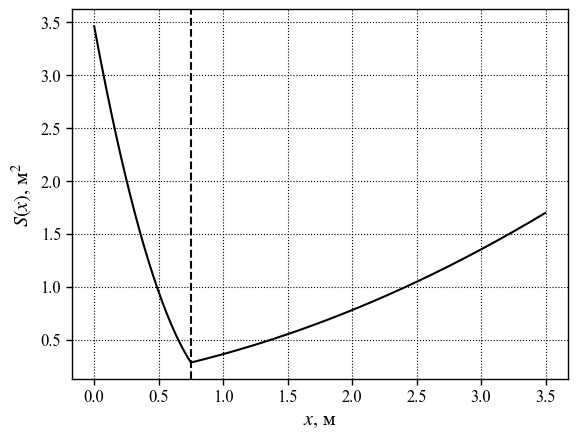

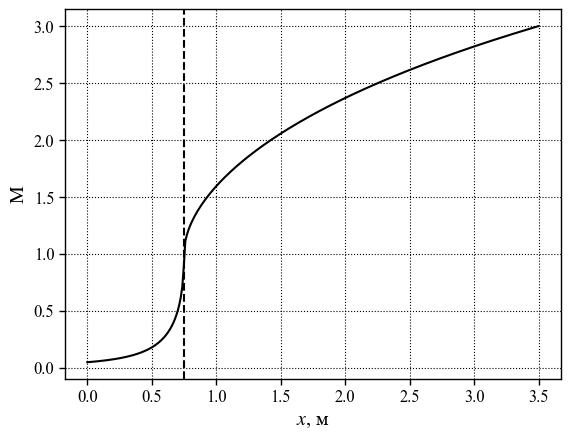

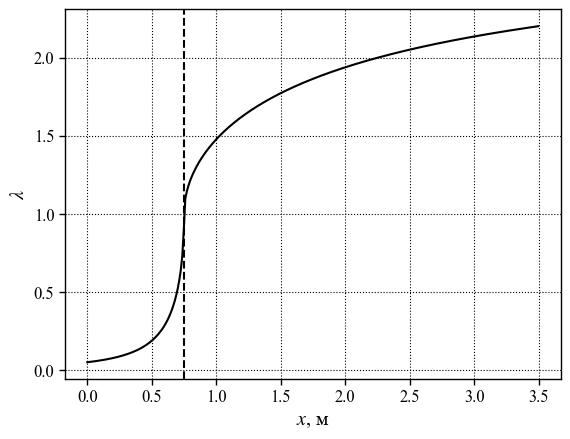

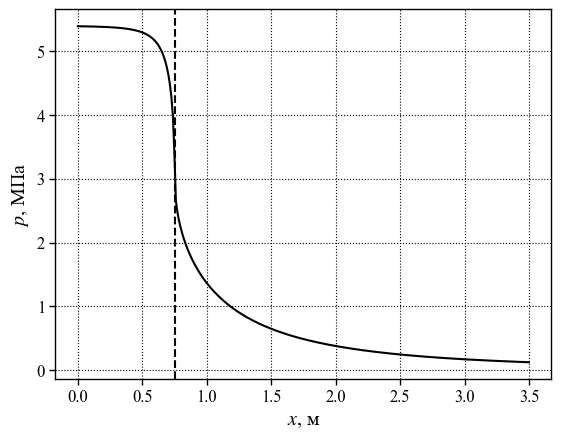

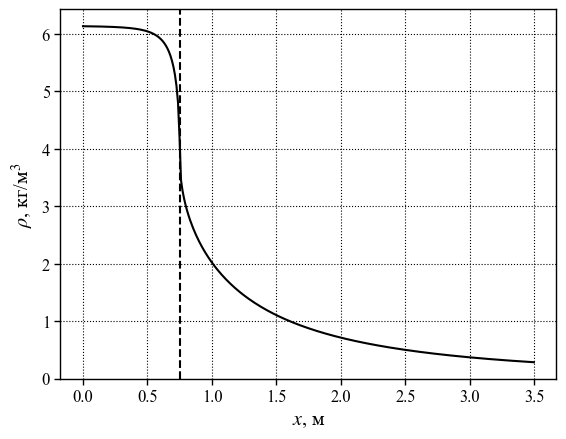

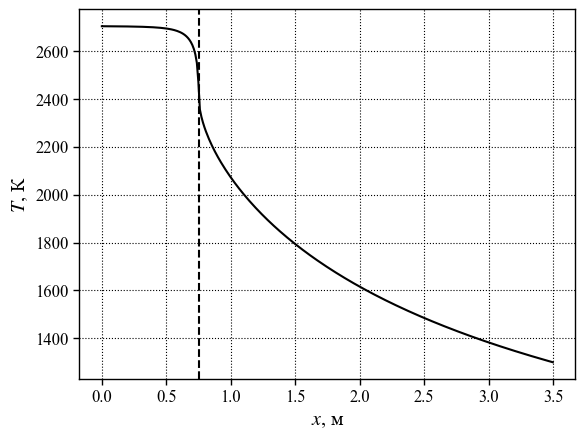

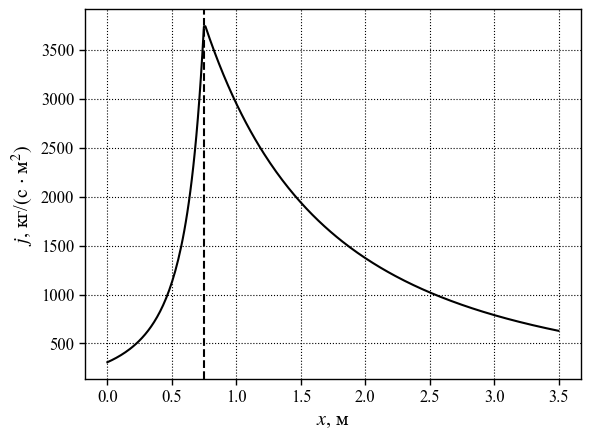

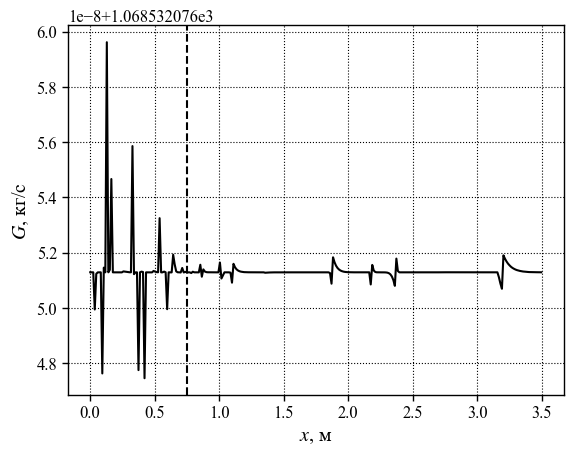

In [11]:
with plt.style.context("../sciart.mplstyle"):
    make_plots(task, noz, sol)
    plt.show()

Разработанная программа не привязана к конкретному варианту.
Достаточно подставить исходные данные — и задача будет решена для них.
В этом и заключается основа автоматизации.

Вряд ли вы сейчас прочувствуете её важность и удобство.
Может показаться, что мы переусложнили код.
Его действительно можно написать в виде небольшого скрипта, как в методическом пособии.
Но когда вы начнёте делать работы без явно заданных исходных данных, когда вам нужно будет эти данные варьировать, анализировать — вот тогда автоматизация для вас заиграет новыми красками.

## Пересчёт длины сопла для обеспечения расчётного режима его работы

Реализуйте пересчёт длины сопла самостоятельно.
Напишите функцию

```{code} python
def adapt_nozzle(task: Task, noz: Nozzle, p_a: float) -> AdaptedNozzle
```

которая возвращает класс данных `AdaptedNozzle`:

In [14]:
@dataclass(frozen=True)
class AdaptedNozzle:
    mach_out: float
    d_out: float
    x_out: float
    dx: float
    dx_percents: float

    def as_dict(self):
        pass    # <- можете реализовать аналогично Solution


def adapt_nozzle(task: Task, noz: Nozzle, p_a: float) -> AdaptedNozzle:
    # Изменить длину сопла для обеспечения расчётного режима истечения.
    pass # <- вместо pass ваш код